![clothing_classification](clothing_classification.png)


Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

In [9]:
# Run the cells below first

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

In [11]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])


train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transforms)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transforms)

dataloader_train = DataLoader(train_data, batch_size=10, shuffle=True, num_workers=2, pin_memory=True)

num_classes = len(train_data.classes)
image_size = train_data[0][0].shape[1]

train size: 60000 test size: 10000
Image Size: 28 x 28,
Classes: 10 ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


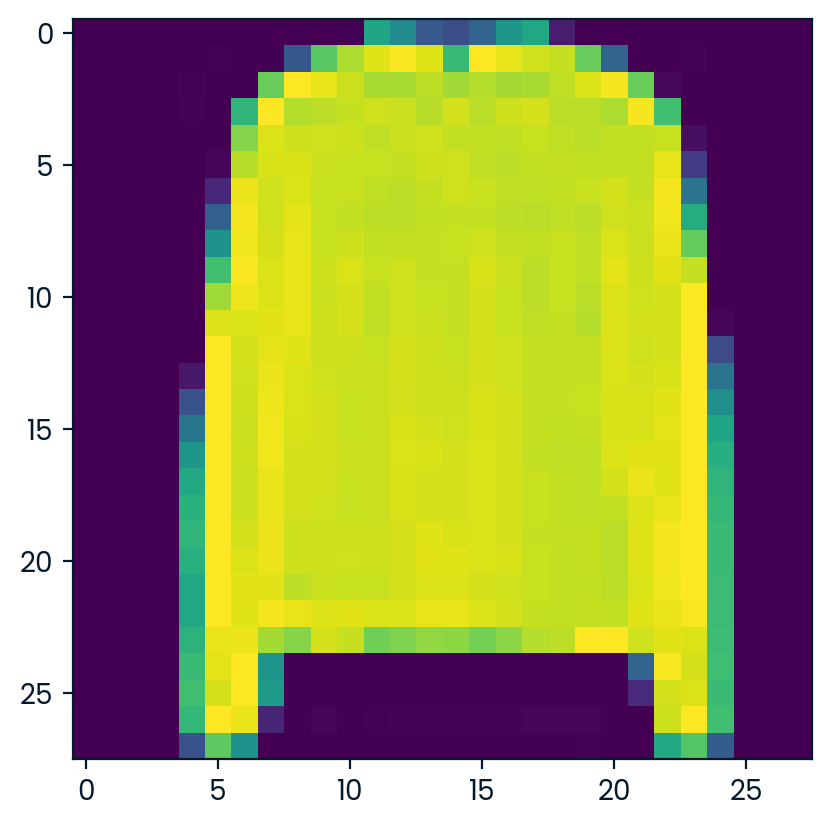

In [12]:
image, label= next(iter(dataloader_train))
print('train size:', len(train_data),'test size:', len(test_data))
print(f"Image Size: {image.shape[2]} x {image.shape[3]},\nClasses: {num_classes} {train_data.classes}")

image = image.squeeze()

plt.imshow(image[0])
plt.show()

In [13]:
# Define CNN
class MultiClassImageClassifier(nn.Module):
    # Define the init method
    def __init__(self, num_classes):
        super(MultiClassImageClassifier, self).__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            # Create a fully connected layer
            nn.Linear(16 * (image_size//2)**2, num_classes)
        )
        
    def forward(self, x):
        # Pass inputs through each layer
        x = self.image_layer(x)
        return x
    
    
# Define training function
def train_model(optimizer, net, num_epochs):
    num_processed = 0
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        running_loss = 0
        num_processed = 0
        for features, labels in dataloader_train:
            features = features.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_processed += len(labels)
        print(f'epoch {epoch}, loss: {running_loss / num_processed}')
        
    train_loss = running_loss / len(dataloader_train)
    print("train_loss",train_loss)

# 0) Elige el dispositivo una sola vez
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Entrenando en:", device)           # "cuda" o "cpu"

# Train for 1 epoch
net = MultiClassImageClassifier(num_classes).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_model(
    optimizer=optimizer,
    net=net,
    num_epochs=1,
)

Entrenando en: cpu
epoch 0, loss: 0.039882261342382604
train_loss 0.398822613423826


In [ ]:
# Testing the model on the test set

# Define the test set DataLoader
dataloader_test = DataLoader(
    test_data,
    batch_size=10,
    shuffle=False,
)
# Define the metrics
accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes)
precision_metric = Precision(task='multiclass', num_classes=num_classes, average=None)
recall_metric = Recall(task='multiclass', num_classes=num_classes, average=None)

# Run model on test set
net.eval()
predictions = []
for i, (features, labels) in enumerate(dataloader_test):
    output = net.forward(features.reshape(-1, 1, image_size, image_size))
    cat = torch.argmax(output, dim=-1)
    predictions.extend(cat.tolist())
    accuracy_metric(cat, labels)
    precision_metric(cat, labels)
    recall_metric(cat, labels)

# Compute the metrics
accuracy = accuracy_metric.compute().item()
precision = precision_metric.compute().tolist()
recall = recall_metric.compute().tolist()
print('Accuracy:', accuracy)
print('Precision (per class):', precision)
print('Recall (per class):', recall)

Accuracy: 0.8862000107765198
Precision (per class): [0.7885462641716003, 0.9867346882820129, 0.8358974456787109, 0.858473002910614, 0.7806859016418457, 0.9873417615890503, 0.7858136296272278, 0.9248554706573486, 0.9681274890899658, 0.94700688123703]
Recall (per class): [0.8949999809265137, 0.9670000076293945, 0.8149999976158142, 0.921999990940094, 0.8650000095367432, 0.9359999895095825, 0.5649999976158142, 0.9599999785423279, 0.972000002861023, 0.9649999737739563]
